In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random

from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.7 MB/s eta 0:00:00


## Данные:
Узлы: веб-страницы университетских сайтов

Ребра: гиперссылки между страницами

Признаки узлов: bag-of-words представление содержимого страниц

Метки классов: категории веб-страниц



In [3]:
from torch_geometric.datasets import WebKB

# Доступные университеты в датасете
dataset = WebKB(root='./data', name='Cornell')
graph = dataset[0]
display(dataset)

Processing...
Done!


cornell()

In [4]:
def display_dataset_info(dataset, dataset_name="Датасет"):
    """
    Отображает подробную информацию о датасете в читаемом формате
    """
    # Основная информация
    basic_info = {
        "Название датасета": dataset_name,
        "Тип датасета": type(dataset).__name__,
        "Количество графов": len(dataset),
        "Количество признаков вершин": dataset.num_node_features,
        "Количество признаков ребер": dataset.num_edge_features if hasattr(dataset, 'num_edge_features') else 0,
        "Количество классов": dataset.num_classes if hasattr(dataset, 'num_classes') else "N/A"
    }

    # Информация о первом графе (если есть данные)
    if len(dataset) > 0:
        data = dataset[0]
        graph_info = {
            "Количество вершин": data.num_nodes,
            "Количество ребер": data.num_edges,
            "Плотность графа": f"{(2 * data.num_edges / (data.num_nodes * (data.num_nodes - 1))):.6f}" if data.num_nodes > 1 else "N/A",
            "Средняя степень": f"{(2 * data.num_edges / data.num_nodes):.2f}" if data.num_nodes > 0 else "N/A"
        }
    else:
        graph_info = {"Количество вершин": "N/A", "Количество ребер": "N/A"}

    # Создаем DataFrame для красивого отображения
    import pandas as pd

    # Основная информация
    basic_df = pd.DataFrame(list(basic_info.items()), columns=["Параметр", "Значение"])

    # Информация о графе
    graph_df = pd.DataFrame(list(graph_info.items()), columns=["Параметр", "Значение"])

    # Объединяем
    full_df = pd.concat([basic_df, graph_df], ignore_index=True)

    # Дополнительная информация о разделении данных
    if len(dataset) > 0 and hasattr(data, 'train_mask'):
        split_info = {
            "Обучающая выборка": data.train_mask.sum().item() if data.train_mask.dim() == 1 else data.train_mask[:, 0].sum().item(),
            "Валидационная выборка": data.val_mask.sum().item() if data.val_mask.dim() == 1 else data.val_mask[:, 0].sum().item(),
            "Тестовая выборка": data.test_mask.sum().item() if data.test_mask.dim() == 1 else data.test_mask[:, 0].sum().item()
        }
        split_df = pd.DataFrame(list(split_info.items()), columns=["Параметр", "Значение"])
        full_df = pd.concat([full_df, split_df], ignore_index=True)

    # Отображаем с улучшенным форматированием
    styled_df = full_df.style\
        .set_properties(**{'text-align': 'left'})\
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#f0f0f0'),
                                       ('font-weight', 'bold'),
                                       ('padding', '8px'),
                                       ('border', '1px solid #ddd')]},
            {'selector': 'td', 'props': [('padding', '8px'),
                                       ('border', '1px solid #ddd')]},
            {'selector': '', 'props': [('border-collapse', 'collapse')]}
        ])\
        .hide(axis='index')\
        .set_caption(f"📊 Детальная информация о датасете: {dataset_name}")

    display(styled_df)

    # Дополнительная текстовая информация
    print("\n📋 Краткое описание:")
    if len(dataset) == 1:
        print(f"   • Это одиночный граф с {data.num_nodes} вершинами и {data.num_edges} ребрами")
        if hasattr(dataset, 'num_classes') and dataset.num_classes > 0:
            print(f"   • Задача: классификация вершин на {dataset.num_classes} классов")
    else:
        print(f"   • Датасет содержит {len(dataset)} отдельных графов")

    if hasattr(data, 'directed') and data.is_directed():
        print("   • Тип графа: направленный")
    else:
        print("   • Тип графа: ненаправленный")

display_dataset_info(dataset, "")

Параметр,Значение
Название датасета,
Тип датасета,WebKB
Количество графов,1
Количество признаков вершин,1703
Количество признаков ребер,0
Количество классов,5
Количество вершин,183
Количество ребер,298
Плотность графа,0.017895
Средняя степень,3.26



📋 Краткое описание:
   • Это одиночный граф с 183 вершинами и 298 ребрами
   • Задача: классификация вершин на 5 классов
   • Тип графа: ненаправленный


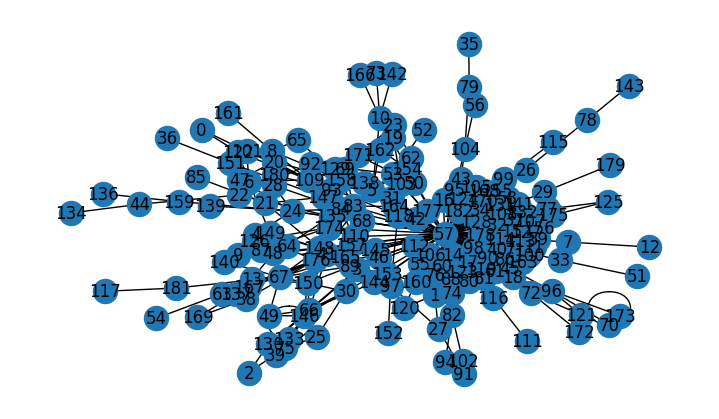

In [5]:
from torch_geometric.utils import to_networkx
G = to_networkx(graph, to_undirected=True)
plt.figure(figsize=(7, 4))
nx.draw(G, with_labels=True)

## DeepWalk

In [6]:
def deep_walk(G, num_walks = 10, walk_length = 5):
    walks = []
    for node in tqdm(G.nodes()):
        for i in range(num_walks):
            actual_node = node
            deep_walk_array = [actual_node]
            for j in range(walk_length):
                neighbors_array = list(G.neighbors(actual_node))
                if len(neighbors_array) > 0:
                    next_node = int(np.random.choice(neighbors_array))
                    deep_walk_array.append(next_node)
                    actual_node = next_node
                else:
                    break
            walks.append(deep_walk_array)
    return walks

## SGD + negative sampling

In [7]:
# обучение эмбеддингов
def train(G_sub, epoch_cnt=50, negative_samples=5):
    walks = deep_walk(G_sub, num_walks=13, walk_length=5)

    emb_sample = nn.Embedding(G_sub.number_of_nodes(), 32)
    nn.init.normal_(emb_sample.weight, mean=0.0, std=0.1)
    optimizer = torch.optim.SGD(emb_sample.parameters(), lr=0.01)

    for epoch in range(epoch_cnt):
        total_loss = 0
        batch_count = 0

        for walk in walks:
            for i, target in enumerate(walk):
                if i < len(walk) - 1:
                    context = walk[i + 1]
                    # positive samplings
                    product = (emb_sample(torch.tensor(target)) * emb_sample(torch.tensor(context))).sum()
                    pred = torch.sigmoid(product)
                    positive_loss = -torch.log(pred)

                    # negative samplings - target и случайные вершины должны быть далеки
                    negative_loss = 0
                    for _ in range(negative_samples):
                        negative_node = random.randint(0, G_sub.number_of_nodes() - 1)
                        # Убедимся, что это действительно негативный пример
                        while negative_node == context or negative_node == target:
                            negative_node = random.randint(0, G_sub.number_of_nodes() - 1)

                        negative_score = (
                                emb_sample(torch.tensor(target)) * emb_sample(torch.tensor(negative_node))).sum()
                        negative_loss += -torch.log(1 - torch.sigmoid(negative_score))

                    negative_loss /= negative_samples  # усредним

                    loss = positive_loss + negative_loss
                    total_loss += loss.item()
                    batch_count += 1

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
        if epoch % 5 == 0:
            avg_loss = total_loss / batch_count
            print(f"Эпоха {epoch}, Loss: {avg_loss:.4f}")
    return emb_sample

In [8]:
deep_walk_embeddings = train(G, negative_samples=5, epoch_cnt=30)

100%|██████████| 183/183 [00:00<00:00, 578.40it/s]


Эпоха 0, Loss: 1.3518
Эпоха 5, Loss: 0.8930
Эпоха 10, Loss: 0.8580
Эпоха 15, Loss: 0.8433
Эпоха 20, Loss: 0.8390
Эпоха 25, Loss: 0.8361


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


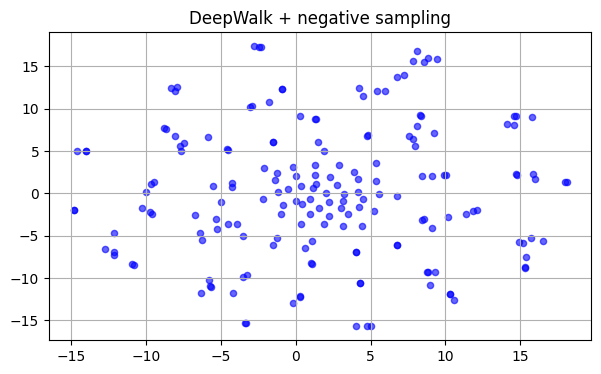

In [27]:
plt.figure(figsize=(7, 4))
embeddings = deep_walk_embeddings.weight.detach().numpy()

# Попробуйте разные комбинации этих параметров:
embeddings_2d = TSNE(
    n_components=2,
    perplexity=25,           # обычно между 5 и 50
    learning_rate='auto',    # или конкретное число, например 200
    n_iter=10000,            # количество итераций
    random_state=11,        # для воспроизводимости
    init='pca',             # или 'pca'
    metric='euclidean'      # или 'cosine'
).fit_transform(embeddings)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=20, color='b')
plt.title("DeepWalk + negative sampling")
plt.grid(True)
plt.show()

## Классифицируем вершины и выведем некоторые их них, принадлежащие одному классу

In [30]:
# Теперь - множества схожих вершин
from sklearn.metrics.pairwise import cosine_similarity

top_cnt = 10

# У нас нумерация отличается от фактических номеров вершин, поэтому преобразуем
all_nodes = sorted([int(node) for node in G.nodes()])

# Создаем mapping: индекс в embeddings -> реальный идентификатор вершины
idx_to_id = {i: node_id for i, node_id in enumerate(all_nodes)}

# Вычисляем попарные косинусные схожести только для вершин графа
node_embeddings = np.array([embeddings[node_id] for node_id in all_nodes])
similarities = cosine_similarity(node_embeddings)

similar_dict = {}
for i, real_node_id in enumerate(all_nodes):
    # Исключаем саму вершину и берем Топ-к
    similar_indices = np.argsort(similarities[i])[::-1][1:top_cnt+1]
    # Конвертируем индексы обратно в реальные идентификаторы вершин
    similar_real_ids = [idx_to_id[idx] for idx in similar_indices]
    similar_dict[real_node_id] = similar_real_ids



# Выводим результаты для нескольких вершин - выведем первые 10

similar_nodes = []

for node in list(G.nodes())[:10]:
    similar_nodes += [sorted(similar_dict[node])]


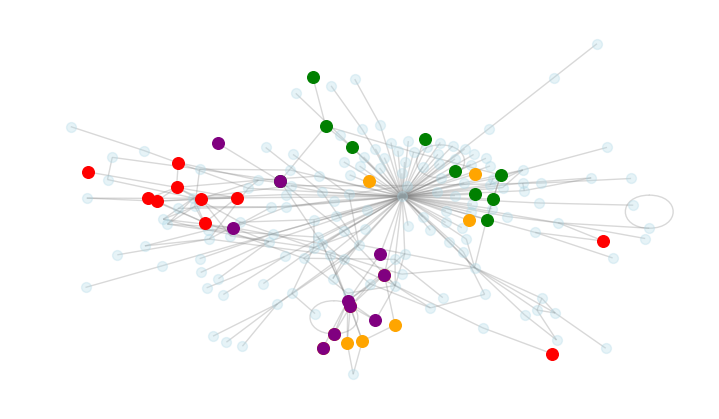

In [31]:
# Ну и попытаемся визуализировать некоторые из похожих вершин, хотя что-то увидеть на такой картинке будет трудно

plt.figure(figsize=(7, 4))

pos = nx.spring_layout(G, seed=42)
nx.draw(G,pos,
        node_color='lightblue',
        node_size=50,
        edge_color='gray',
        alpha=0.3,
        with_labels=False)

nx.draw_networkx_nodes(graph,pos,
                          nodelist=similar_nodes[0],
                          node_color='red',
                          node_size=70)

nx.draw_networkx_nodes(graph,pos,
                          nodelist=similar_nodes[1],
                          node_color='green',
                          node_size=70)

nx.draw_networkx_nodes(graph,pos,
                          nodelist=similar_nodes[2],
                          node_color='orange',
                          node_size=70)

nx.draw_networkx_nodes(graph,pos,
                          nodelist=similar_nodes[3],
                          node_color='purple',
                          node_size=70)

## Как будто дествительно есть какая-то локализация, например, красных вершин, локализация фиолетовых

## Node2Vec

In [12]:
# Реализуем случайные блуждания для node2vec


def deep_walk_node2vec(G, num_walks=10, walk_length=5, p=1, q=1):
    walks = []

    nodes = G.nodes()
    neighbors = {node: list(G.neighbors(node)) for node in nodes}

    for node in tqdm(nodes):
        for i in range(num_walks):
            actual_node = node
            deep_walk_array = [actual_node]
            for j in range(walk_length):
                neighbors_array = list(G.neighbors(actual_node))
                if len(neighbors_array) == 0:
                    break
                elif len(deep_walk_array) == 1:
                    deep_walk_array.append(random.choice(neighbors_array))
                else:
                    prev = deep_walk_array[-2]
                    weights = []
                    for n in neighbors_array:
                        if n == prev: # Т е как раз сравниваем с предыдущей вершиной в случае p
                            weights.append(1 / p)
                        elif prev in neighbors.get(n,[]):
                            weights.append(1)
                        else:
                            weights.append(1 / q)

                    weights = np.array(weights)
                    deep_walk_array.append(np.random.choice(neighbors_array, p=weights / weights.sum()))
            walks.append(deep_walk_array)
    return walks

In [32]:
def train_node2vec(G_sub, epoch_cnt=50, negative_samples=5, p=1.0, q=1.0):
    """Обучение эмбеддингов через Node2Vec"""

    # Генерация Node2Vec блужданий
    walks = deep_walk_node2vec(G_sub, num_walks=13, walk_length=5, p = p, q = q)
    print(f"Сгенерировано {len(walks)} Node2Vec блужданий")

    # Создаем модель для эмбеддингов
    node_list = sorted(G_sub.nodes())

    emb_sample = nn.Embedding(G_sub.number_of_nodes(), 32)
    nn.init.normal_(emb_sample.weight, mean=0.0, std=0.1)
    optimizer = torch.optim.SGD(emb_sample.parameters(), lr=0.01)

    for epoch in range(epoch_cnt):
        total_loss = 0
        batch_count = 0

        for walk in walks:
            walk_indices = [node_list.index(node) for node in walk]
            for i, target in enumerate(walk_indices):
                if i < len(walk_indices) - 1:
                    context = walk_indices[i + 1]
                    # positive samplings
                    product = (emb_sample(torch.tensor(target)) * emb_sample(torch.tensor(context))).sum()
                    pred = torch.sigmoid(product)
                    positive_loss = -torch.log(pred)

                    # negative samplings - target и случайные вершины должны быть далеки
                    negative_loss = 0
                    for _ in range(negative_samples):
                        negative_node = random.randint(0, G_sub.number_of_nodes() - 1)
                        # Убедимся, что это действительно негативный пример
                        while negative_node == context or negative_node == target:
                            negative_node = random.randint(0, G_sub.number_of_nodes() - 1)

                        negative_score = (
                                emb_sample(torch.tensor(target)) * emb_sample(torch.tensor(negative_node))).sum()
                        negative_loss += -torch.log(1 - torch.sigmoid(negative_score))

                    negative_loss /= negative_samples  # усредним

                    loss = positive_loss + negative_loss
                    total_loss += loss.item()
                    batch_count += 1

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
        if epoch % 5 == 0:
            avg_loss = total_loss / batch_count
            print(f"Эпоха {epoch}, Loss: {avg_loss:.4f}")
    return emb_sample

In [14]:
node2vec_embeddings = train_node2vec(G, p=1, q=2, epoch_cnt=30)

100%|██████████| 183/183 [00:00<00:00, 437.60it/s]


Сгенерировано 2379 Node2Vec блужданий
Эпоха 0, Loss: 1.1616
Эпоха 5, Loss: 0.8656
Эпоха 10, Loss: 0.8177
Эпоха 15, Loss: 0.8045
Эпоха 20, Loss: 0.7951
Эпоха 25, Loss: 0.7878


In [17]:
node2vec_embeddings

Embedding(183, 32)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


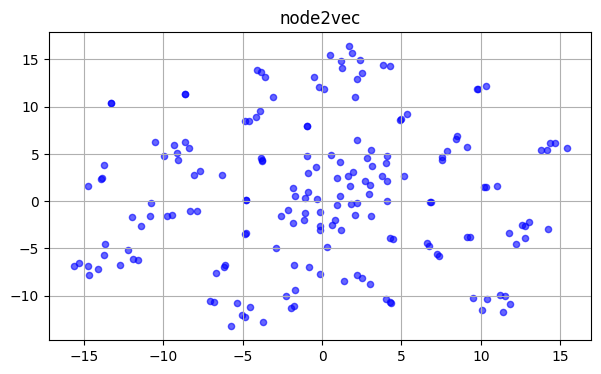

In [33]:
# Визуализируем с помощью t-SNE - при снижении размерности он просто умеет сохранять расстояния между объектами, которые были близки и в пространстве большой размерности
plt.figure(figsize=(7, 4))
embeddings = node2vec_embeddings.weight.detach().numpy()

# Попробуйте разные комбинации этих параметров:
embeddings_2d = TSNE(
    n_components=2,
    perplexity=25,           # обычно между 5 и 50
    learning_rate='auto',    # или конкретное число, например 200
    n_iter=10000,            # количество итераций
    random_state=11,        # для воспроизводимости
    init='pca',             # или 'pca'
    metric='euclidean'      # или 'cosine'
).fit_transform(embeddings)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=20, color='b')
plt.title("node2vec")
plt.grid(True)
plt.show()

## Сравнения

In [23]:
from sklearn.model_selection import train_test_split
# За классификатор возьмем обычный градиентный бустинг

from sklearn.ensemble import GradientBoostingClassifier

# Ребра, которые уже есть
positive_edges = list(G.edges())
nodes = list(G.nodes())

# Сюда сложим ребра которых нет
negative_edges = []

while len(negative_edges) < len(positive_edges):
    u, v = random.sample(nodes, 2)
    if not G.has_edge(u, v): # Т е если ребра реально нет - то подходит и складываем в массив
        negative_edges.append((u, v))

# Создаем mapping: node_id -> embedding_index
node_to_idx = {node: i for i, node in enumerate(sorted(nodes))}

# Эмбеддинги есть, но создадим признаки
def create_features(embeddings, edges):
        features = []
        for u, v in edges:
            u_idx = node_to_idx[u]
            v_idx = node_to_idx[v]

            feature = np.concatenate([
                embeddings[u_idx],
                embeddings[v_idx],
                embeddings[u_idx] * embeddings[v_idx]
            ])
            features.append(feature)
        return np.array(features)



gbc_deep_walk = GradientBoostingClassifier(n_estimators=100, random_state=100)
gbc_node2vec = GradientBoostingClassifier(n_estimators=100, random_state=100)

deep_walk_embeddings_result = deep_walk_embeddings.weight.detach().numpy()
node2vec_embeddings_result = node2vec_embeddings.weight.detach().numpy()

X_deep_walk = create_features(deep_walk_embeddings_result, positive_edges + negative_edges)
X_node2vec = create_features(node2vec_embeddings_result, positive_edges + negative_edges)
y = np.array([1]*len(positive_edges) + [0]*len(negative_edges))


X_deep_walk_train, X_deep_walk_test, y_train, y_test = train_test_split(X_deep_walk, y, test_size=0.2, random_state=47, stratify=y)
X_node2vec_train, X_node2vec_test, _, _ = train_test_split(X_node2vec, y, test_size=0.2, random_state=47, stratify=y)

gbc_deep_walk.fit(X_deep_walk_train, y_train)
gbc_node2vec.fit(X_node2vec_train, y_train)

GradientBoostingClassifier(random_state=100)

In [24]:
print(classification_report(y_test, gbc_deep_walk.predict(X_deep_walk_test)))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        56
           1       0.93      1.00      0.97        56

    accuracy                           0.96       112
   macro avg       0.97      0.96      0.96       112
weighted avg       0.97      0.96      0.96       112



In [25]:
print(classification_report(y_test, gbc_node2vec.predict(X_node2vec_test)))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        56
           1       0.97      1.00      0.98        56

    accuracy                           0.98       112
   macro avg       0.98      0.98      0.98       112
weighted avg       0.98      0.98      0.98       112



## Результаты на самом деле и в первом, и во втором методе хорошие. Node2vec даже как будто где-то переобучилась. Тем не менее, метрики по node2vec чуть лучше, где-то даже есть precision=1 и recall=1